# **Deep Neural Networks**

In this practice, we will work with a neural network composed of an input layer, 3 hidden layers, and an output layer.

- Overfitting / Underfitting
- Dropout
- Parameter Inicialization
- Early Stopping
- Quantization


In [ ]:
#@title Data and Imports

# General modules
import numpy as np
import pandas as pd

# Data processing modules
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from torch.utils.data.dataloader import DataLoader
from sklearn.model_selection import train_test_split

# Plotting modules
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Dataset



Let's create a synthetic dataset to do the experiments. The *make_classification* function from the *sklearn.datasets* module is used to generate a synthetic dataset for classification tasks. The parameters passed to this function determine the characteristics of the dataset.

We will use a dataset composed of two classes and 1000 rows.

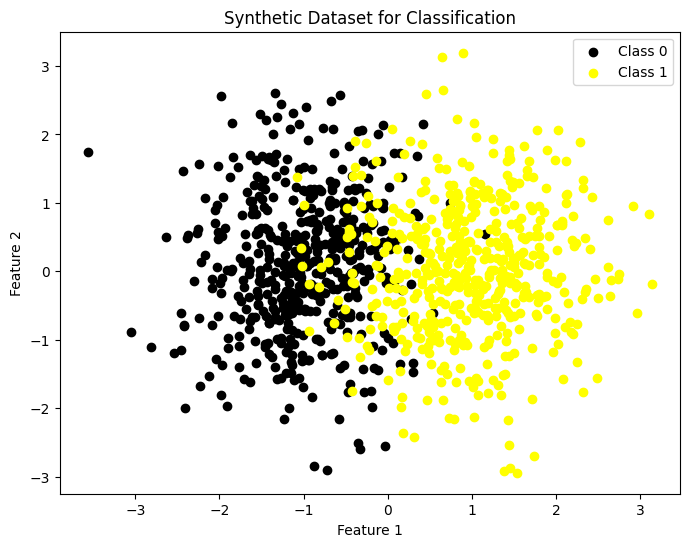

In [ ]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=1, n_redundant=0,
                           n_clusters_per_class=1, flip_y=0, class_sep=1, random_state=42)

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='black', marker='o', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='yellow', marker='o', label='Class 1')
plt.title('Synthetic Dataset for Classification')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [ ]:
y = pd.get_dummies(y).values  # One-hot encode the target

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Deep Neural Network

In [ ]:
#@title Activation Functions

def sigmoid(x):
    # Clip values to avoid overflow
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu_derivative(x):
    return (x > 0).astype(int)

In [ ]:
#@title Loss Function

def loss_function(y_true, y_pred):
  epsilon = np.finfo(float).eps
  return -np.mean(y_true * np.log(y_pred + epsilon))

def loss_function_derivative(y_true, y_pred):
    epsilon = np.finfo(float).eps
    return (y_pred - y_true) / (y_pred * (1 - y_pred) + epsilon)

In [ ]:
#@title Auxiliary Functions

def evaluate_accuracy(model, x, y):
    predictions = model.predict(x)
    accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y, axis=1))
    return accuracy

def plot_losses(all_losses):
    plt.figure(figsize=(10, 6))
    for i, fold_losses in enumerate(all_losses):
        plt.plot(range(1, len(fold_losses) + 1), fold_losses, label=f'Fold {i + 1}')

    average_losses = np.mean(all_losses, axis=0)
    plt.plot(range(1, len(average_losses) + 1), average_losses, label='Average', linewidth=2, color='black')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Losses Across Folds')
    plt.legend()
    plt.show()

def summary(model):
    # Return string
    summary = ''
    summary += "\nModel Architecture:\n"
    summary += "=" * 20 + "\n"
    summary += "{:<20} {:<20}\n".format("Layer Type", "Nº of Neurons")
    summary += "-" * 20 + "\n"
    summary += "{:<20} {:<20}\n".format("Input Layer", str(model.layer_sizes[0]))
    summary += "-" * 20 + "\n"
    for i in range(1, len(model.layer_sizes) - 1):
        summary += "{:<20} {:<20}\n".format("Hidden Layer " + str(i), str(model.layer_sizes[i]))
        summary += "-" * 20 + "\n"
    summary += "{:<20} {:<20}\n".format("Output Layer", str(model.layer_sizes[-1]))
    summary += "=" * 20 + "\n"

    return summary

# Auxiliary function to plot the decision boundary
def plot_decision_boundary(model, x):
    x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
    y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5

    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)

    return xx, yy, Z

In [ ]:
#@title Neural Network

class DL_Model:
    def __init__(self, learning_rate, epochs, layer_sizes, dropout_prob=0):
        self.weights = {}
        self.biases = {}
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.layer_sizes = layer_sizes
        self.input_size = layer_sizes[0]
        self.output_size = layer_sizes[-1]
        self.dropout_prob = dropout_prob
        self.losses = []
        self.val_losses = []
        self.random_state = np.random.RandomState(42)

    def initialize_parameters(self):
        # Initialize weights and biases
        for i in range(len(self.layer_sizes) - 1):
            self.weights[i] = self.random_state.randn(self.layer_sizes[i], self.layer_sizes[i + 1])
            self.biases[i] = np.zeros((1, self.layer_sizes[i + 1]))

    def forward(self, x):
        # Forward pass
        self.activations = {}
        self.activations[0] = x
        for i in range(len(self.layer_sizes) - 1):
            self.activations[i + 1] = np.dot(self.activations[i], self.weights[i]) + self.biases[i]
            if i != len(self.layer_sizes) - 2:
                self.activations[i + 1] = relu(self.activations[i + 1])
            else:
                self.activations[i + 1] = sigmoid(self.activations[i + 1])

    def backward(self, y):
        # Backward pass
        self.gradients = {}
        loss_derivative = loss_function_derivative(y, self.activations[len(self.layer_sizes) - 1])
        self.gradients[len(self.layer_sizes) - 2] = loss_derivative
        for i in range(len(self.layer_sizes) - 2, 0, -1):
            self.gradients[i - 1] = np.dot(self.gradients[i], self.weights[i].T) * relu_derivative(self.activations[i])

    def clip_gradients(self):
        max_grad_norm = 1.0
        for i in range(len(self.layer_sizes) - 1):
            grad_norm = np.linalg.norm(self.gradients[i])
            if grad_norm > max_grad_norm:
                scale = max_grad_norm / (grad_norm + 1e-6)  # Avoid division by zero
                self.gradients[i] *= scale

    def update_parameters(self):
        # Update weights and biases
        self.clip_gradients()
        for i in range(len(self.layer_sizes) - 1):
            self.weights[i] -= self.learning_rate * np.dot(self.activations[i].T, self.gradients[i])
            self.biases[i] -= self.learning_rate * np.sum(self.gradients[i], axis=0, keepdims=True)

    def fit(self, x, y, validation_data=None):
        self.initialize_parameters()
        for _ in range(self.epochs):
            self.forward(x)
            self.backward(y)
            self.update_parameters()
            self.losses.append(loss_function(y, self.activations[len(self.layer_sizes) - 1]))

            x_val, y_val = validation_data
            self.forward(x_val)
            self.val_losses.append(loss_function(y_val, self.activations[len(self.layer_sizes) - 1]))
            print(f"\rEpoch:{_+1}, Loss:{self.losses[-1]:.4f}, Val Loss:{self.losses[-1]:.4f}",end="")

    def predict(self, x):
        self.forward(x)
        return self.activations[len(self.layer_sizes) - 1]

# Train and Predict

In [ ]:
#@title Hyperparameters initialization

input_size = x_train.shape[1]
output_size = y_train.shape[1]
hidden_layers = [512, 128, 32, 32]
layer_sizes = [input_size] + hidden_layers + [output_size]
learning_rate = 0.0001
epochs = 1000

In [ ]:
#@title Training

nn = DL_Model(learning_rate, epochs, layer_sizes)
nn.fit(x_train, y_train, validation_data=(x_val, y_val))

Epoch:1000, Loss:0.1177, Val Loss:0.1177

Accuracy: 0.915


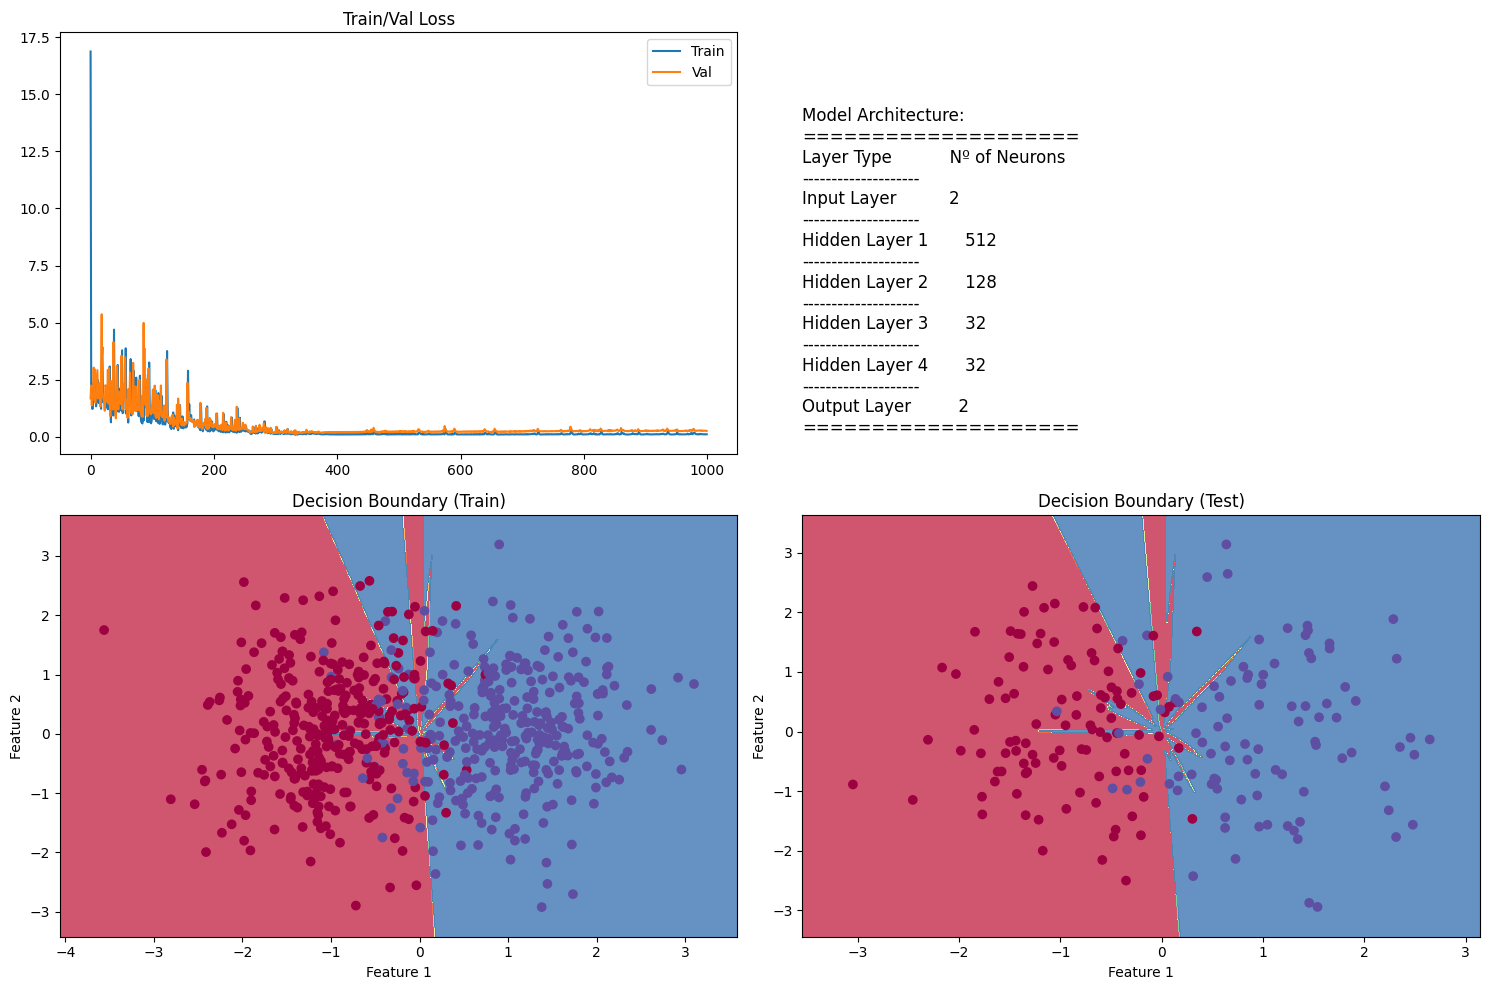

In [ ]:
#@title Plot results

accuracy = []
xx_train, yy_train = [], []
xx_test, yy_test = [], []
Z_train, Z_test = [], []

accuracy.append(evaluate_accuracy(nn, x_test, y_test))
print("Accuracy:", accuracy[0])

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(range(nn.epochs), nn.losses)
axes[0, 0].plot(range(nn.epochs), nn.val_losses)
axes[0, 0].set_title("Train/Val Loss")
axes[0, 0].legend(['Train', 'Val'])

# Show summary
axes[0, 1].axis('off')
axes[0, 1].text(0, 0, summary(nn), fontsize=12)

xx_aux, yy_aux, Z_aux = plot_decision_boundary(nn, x_train)
xx_train.append(xx_aux)
yy_train.append(yy_aux)
Z_train.append(Z_aux)
axes[1, 0].contourf(xx_train[0], yy_train[0], Z_train[0], cmap=plt.cm.Spectral, alpha=0.8)
axes[1, 0].scatter(x_train[:, 0], x_train[:, 1], c=np.argmax(y_train, axis=1), cmap=plt.cm.Spectral)
axes[1, 0].set_title("Decision Boundary (Train)")
axes[1, 0].set_xlabel("Feature 1")
axes[1, 0].set_ylabel("Feature 2")

xx_aux, yy_aux, Z_aux = plot_decision_boundary(nn, x_test)
xx_test.append(xx_aux)
yy_test.append(yy_aux)
Z_test.append(Z_aux)
axes[1, 1].contourf(xx_test[0], yy_test[0], Z_test[0], cmap=plt.cm.Spectral, alpha=0.8)
axes[1, 1].scatter(x_test[:, 0], x_test[:, 1], c=np.argmax(y_test, axis=1), cmap=plt.cm.Spectral)
axes[1, 1].set_title("Decision Boundary (Test)")
axes[1, 1].set_xlabel("Feature 1")
axes[1, 1].set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

# **Questions**


1. **How did the model's performance evolve over time?**

Analizando la evolución del rendimiento del modelo, se obserba como la gráfica de pérdida (Train/Val Loss), que tanto las barras azules (entrenamiento), como las naranjas (validación) disminuyen progresivamente y convergen de manera adecuada. Esto indica que la red está aprendiendo correctamente y generalizando bien, ya que la pérdida de validación acompaña el descenso de la pérdida de entrenamiento, confirmando un aprendizaje correcto y sin overfitting.

# Symmetric Uniform Quantization (signed)
https://arxiv.org/pdf/2106.08295

### Domain
$$
q \in \mathbb{Z},
$$
$$
q_{\min} = -2^{\,n-1},\; q_{\max} = 2^{\,n-1} - 1
$$
$$
q_{\min} = -128,\; q_{\max} = 127
$$


---

### Scale
$$
\alpha = \max |x|
$$

$$
s = \frac{\alpha}{127}
$$

---

### Quantization
$$
q = Q(x) =
\operatorname{clip}
\left(
\operatorname{round}\!\left( \frac{x}{s} \right),
qmin,\;qmax
\right)
$$

---

### Dequantisation
$$
\hat{x} = D(q) = s \cdot q
$$

$$
|x - \hat{x}| \le \frac{s}{2}
$$

---

### Pesos
$$
\mathbf{W}_q = Q(\mathbf{W})
$$

$$
s_W = \frac{\max |W|}{127}
$$

---

### Inference
$$
\mathbf{y} \approx
s_x s_W
\left(
\mathbf{x}_q \mathbf{W}_q
\right)
$$

---

### Bias
$$
b_q =
\operatorname{round}
\left(
\frac{b}{s_x s_W}
\right)
$$

---

### ReLU
$$
\mathrm{ReLU}_q(q) = \max(0,q)
$$

---


In [ ]:
#TODO: complete the next function
def quantize_tensor(tensor, n_bits=8):
    qmin = -2**(n_bits - 1)
    qmax = 2**(n_bits - 1) - 1

    max_val = np.max(np.abs(tensor))
    scale = max_val / 127

    tensor_q = np.clip(np.round(tensor / scale), qmin, qmax).astype(np.int32)

    return tensor_q, scale

def quantize_model_parameters(model, n_bits=8):
    quantized_model = {
        "weights_q": {},
        "biases_q": {},
        "scales_w": {},
        "scales_b": {}
    }

    for i in model.weights.keys():
        w_q, w_scale = quantize_tensor(model.weights[i], n_bits)
        b_q, b_scale = quantize_tensor(model.biases[i], n_bits)

        quantized_model["weights_q"][i] = w_q
        quantized_model["biases_q"][i] = b_q
        quantized_model["scales_w"][i] = w_scale
        quantized_model["scales_b"][i] = b_scale

    return quantized_model

def dequantize_tensor(tensor_q, scale):
    return tensor_q.astype(np.float32) * scale

quantized_params = quantize_model_parameters(nn, n_bits=8)

# Accedemos y mostramos los valores de los pesos de la primera capa
W0_q = quantized_params["weights_q"][0]
W0_scale = quantized_params["scales_w"][0]
print(W0_q)
print(W0_scale)

def model_memory_float(model):
    total_bytes = 0

    for i in model.weights:
        total_bytes += model.weights[i].nbytes
        total_bytes += model.biases[i].nbytes

    return total_bytes

def model_memory_quantized(quantized_params):
    total_bytes = 0

    for i in quantized_params["weights_q"]:
        Wq = quantized_params["weights_q"][i]
        bq = quantized_params["biases_q"][i]

        # Weights INT8 → 1 byte each
        total_bytes += Wq.size * 1

        # Bias INT8 → 1 byte each element
        total_bytes += bq.size * 1

        # Scales (float32)
        total_bytes += 4  # scale_w
        total_bytes += 4  # scale_b

    return total_bytes

float_mem = model_memory_float(nn)
quant_mem = model_memory_quantized(quantized_params)

print(f"Model Memory float32: {float_mem / 1024:.2f} KB")
print(f"Model Memory Quantised INT8: {quant_mem / 1024:.2f} KB")
print(f"Reduction: {100 * (1 - quant_mem / float_mem):.2f}%")


[[ 16  -5  21 ... -27   9  -2]
 [ -8 -30 -19 ... -19  -1  71]]
0.03033311167602537
Memoria modelo float32: 566.02 KB
Memoria modelo cuantizado INT8: 70.79 KB
Reducción: 87.49%


# Improving our neural network

Now we are going to implement some techniques to improve the performance of our neural network during training so that it generalizes better before the test data.

# Parameter inizialization

**Xavier Initialization** is a technique designed to address the issue of maintaining a constant variance for activations throughout the layers of a deep neural network. The primary objective is to prevent the gradients from becoming too small or too large, a phenomenon often referred to as the vanishing or exploding gradients problem. This approach is particularly important because if the variance of the activations varies significantly across layers, it can lead to unstable convergence behavior during training.

Unlike random initialization, which draws weights from a zero-mean Gaussian distribution and risks unstable activations, Xavier Initialization uses a uniform distribution bounded by: \

 $$
\pm \frac{\sqrt{6}}{\sqrt{n_i + n_{i+1}}}
$$

where $n_{i}$ and $n_{i+1}$ represent the number of neurons in the adjacent layers. This method promotes stable convergence during training and is particularly beneficial for deep networks, as discussed in [Understanding the difficulty of training deep feedforward neural networks](https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

**He Initialization**, also known as He Normal Initialization, is a technique designed for initializing the weights of deep neural networks that use ReLU activation functions. The key idea behind He Initialization is to set the initial weights of the network such that the variance remains the same for both inputs and outputs throughout the network.

$$
  \sqrt{\frac{2}{n_i}}
$$

In [ ]:
# To-Do
# n_i = self.layer_sizes[i]
def initialize_parameters(self):
        # Initialize weights and biases
        for i in range(len(self.layer_sizes) - 1):
            if i < len(self.layer_sizes) - 2: # He initialization for ReLU (all layers except last)
                std_dev = np.sqrt(2 / self.layer_sizes[i])
            else:  # Xavier initialization for Sigmoid (last layer)
                std_dev = np.sqrt(2 / (self.layer_sizes[i] + self.layer_sizes[i + 1]))
            self.weights[i] = self.random_state.normal(0, std_dev, (self.layer_sizes[i], self.layer_sizes[i + 1]))
            self.biases[i] = np.zeros((1, self.layer_sizes[i + 1]))

# Replace the function
DL_Model.initialize_parameters = initialize_parameters


SyntaxError: invalid syntax (<ipython-input-11-7e49f33a9da4>, line 7)

In [ ]:
nn = DL_Model(learning_rate, epochs, layer_sizes)
nn.fit(x_train, y_train, validation_data=(x_val, y_val))

In [ ]:
#@title Plot results

accuracy.append(evaluate_accuracy(nn, x_test, y_test))
print("Accuracy:", accuracy[1])

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(range(nn.epochs), nn.losses)
axes[0, 0].plot(range(nn.epochs), nn.val_losses)
axes[0, 0].set_title("Loss")
axes[0, 0].legend(['Train', 'Val'])

# Show summary
axes[0, 1].axis('off')
axes[0, 1].text(0, 0, summary(nn), fontsize=12)

xx_aux, yy_aux, Z_aux = plot_decision_boundary(nn, x_train)
xx_train.append(xx_aux)
yy_train.append(yy_aux)
Z_train.append(Z_aux)
axes[1, 0].contourf(xx_train[1], yy_train[1], Z_train[1], cmap=plt.cm.Spectral, alpha=0.8)
axes[1, 0].scatter(x_train[:, 0], x_train[:, 1], c=np.argmax(y_train, axis=1), cmap=plt.cm.Spectral)
axes[1, 0].set_title("Decision Boundary (Train)")
axes[1, 0].set_xlabel("Feature 1")
axes[1, 0].set_ylabel("Feature 2")

xx_aux, yy_aux, Z_aux = plot_decision_boundary(nn, x_test)
xx_test.append(xx_aux)
yy_test.append(yy_aux)
Z_test.append(Z_aux)
axes[1, 1].contourf(xx_test[1], yy_test[1], Z_test[1], cmap=plt.cm.Spectral, alpha=0.8)
axes[1, 1].scatter(x_test[:, 0], x_test[:, 1], c=np.argmax(y_test, axis=1), cmap=plt.cm.Spectral)
axes[1, 1].set_title("Decision Boundary (Test)")
axes[1, 1].set_xlabel("Feature 1")
axes[1, 1].set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

# Dropout

We are going to adapt the feed-forward and backpropagation functions in order to apply dropout.

In [ ]:
# Feed forward with dropout
def forward_with_dropout(self, x):
    # Forward pass
    self.activations = {}
    self.activations[0] = x
    self.dropout_masks = {}
    for i in range(len(self.layer_sizes) - 1):
        self.activations[i + 1] = np.dot(self.activations[i], self.weights[i]) + self.biases[i]
        if i != len(self.layer_sizes) - 2:
            self.activations[i + 1] = relu(self.activations[i + 1])
            self.activations[i + 1], self.dropout_masks[i] = self.apply_dropout(self.activations[i + 1])
        else:
            self.activations[i + 1] = sigmoid(self.activations[i + 1])

def backward_with_dropout(self, y):
    # Backward pass
    self.gradients = {}
    loss_derivative = loss_function_derivative(y, self.activations[len(self.layer_sizes) - 1])
    self.gradients[len(self.layer_sizes) - 2] = loss_derivative
    for i in range(len(self.layer_sizes) - 2, 0, -1):
        self.gradients[i - 1] = np.dot(self.gradients[i], self.weights[i].T) * relu_derivative(self.activations[i])
        self.gradients[i - 1] *= self.dropout_masks[i - 1]

DL_Model.feed_forward = forward_with_dropout
DL_Model.backpropagation = backward_with_dropout

Implementing dropout will help in preventing overfitting by randomly disabling a subset of neurons during each training iteration, thus forcing the network to learn more robust features that are not reliant on any specific set of neurons. This technique often results in a more generalized model with better performance on unseen data.



In [ ]:
def apply_dropout(self, a):
        # Generate a random matrix D with the same shape as the input activations (a).
        # Each element of D is drawn from a uniform distribution over [0, 1).
        # Note: use self.random_state to generate randoms
        D = self.random_state.rand(*a.shape)

        # Create a dropout mask by setting elements of D to 1 if they are more than
        # the dropout probability (self.dropout_prob), else to 0.
        # This mask will randomly "drop" a portion of the activations.
        dropout_mask = (D > self.dropout_prob).astype(int)

        # Apply the dropout mask to the activations (a).
        # This sets a subset of a's elements to zero, effectively "dropping" them.
        a_dropped = a * dropout_mask

        # To compensate for the reduced number of active neurons, we scale up the remaining activations.
        # This is done to maintain the expected sum of activations, which is important for
        # not altering the behavior of the layer during inference.
        a_scaled = a_dropped / (1 - self.dropout_prob)

        return a_scaled, dropout_mask

DL_Model.apply_dropout = apply_dropout


In [ ]:
# Ahora entrena la red con el dropout implentado
nn = DL_Model(learning_rate, epochs, layer_sizes, dropout_prob=0.1)
nn.fit(x_train, y_train, validation_data=(x_val, y_val))

In [ ]:
#@title Plot results

accuracy.append(evaluate_accuracy(nn, x_test, y_test))
print("Accuracy:", accuracy[2])

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(range(nn.epochs), nn.losses)
axes[0, 0].plot(range(nn.epochs), nn.val_losses)
axes[0, 0].set_title("Loss")

# Show summary
axes[0, 1].axis('off')
axes[0, 1].text(0, 0, summary(nn), fontsize=12)

xx_aux, yy_aux, Z_aux = plot_decision_boundary(nn, x_train)
xx_train.append(xx_aux)
yy_train.append(yy_aux)
Z_train.append(Z_aux)
axes[1, 0].contourf(xx_train[2], yy_train[2], Z_train[2], cmap=plt.cm.Spectral, alpha=0.8)
axes[1, 0].scatter(x_train[:, 0], x_train[:, 1], c=np.argmax(y_train, axis=1), cmap=plt.cm.Spectral)
axes[1, 0].set_title("Decision Boundary (Train)")
axes[1, 0].set_xlabel("Feature 1")
axes[1, 0].set_ylabel("Feature 2")

xx_aux, yy_aux, Z_aux = plot_decision_boundary(nn, x_test)
xx_test.append(xx_aux)
yy_test.append(yy_aux)
Z_test.append(Z_aux)
axes[1, 1].contourf(xx_test[2], yy_test[2], Z_test[2], cmap=plt.cm.Spectral, alpha=0.8)
axes[1, 1].scatter(x_test[:, 0], x_test[:, 1], c=np.argmax(y_test, axis=1), cmap=plt.cm.Spectral)
axes[1, 1].set_title("Decision Boundary (Test)")
axes[1, 1].set_xlabel("Feature 1")
axes[1, 1].set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

# Early Stopping

Based on our results, we can estimate that after 2500 epochs, our model stats overfitting to the training set.

Early stopping halts the training process once the model’s performance on a validation set starts to deteriorate, thereby preventing the model from learning noise and irrelevant patterns in the training data. By stopping the training early, it saves computational resources and time, as the model no longer processes through unnecessary epochs of training that don’t improve generalization.

In [ ]:
# Early Stopping
def fit(self, x, y, batch_size=32, validation_data=None, patience=10):
    self.initialize_parameters()

    best_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(self.epochs):
      self.forward(x)
      self.backward(y)
      self.update_parameters()
      self.losses.append(loss_function(y, self.activations[len(self.layer_sizes) - 1]))

      
      if validation_data is not None:
          x_val, y_val = validation_data
          
          # Calculate validation loss for the current epoch (requires forward pass with val data)
          # Note: We need to temporarily store val activations separately or handle forward carefully
          # In this simple implementation, forward overwrites self.activations, 
          # which is fine as we are at the end of the step.
          self.forward(x_val)
          val_pred = self.activations[len(self.layer_sizes) - 1]
          val_loss = loss_function(y_val, val_pred)
          
          self.val_losses.append(val_loss)

          if val_loss < best_loss:
              best_loss = val_loss
              epochs_without_improvement = 0
          else:
              epochs_without_improvement += 1

          if epochs_without_improvement >= patience:
              print(f"\nEarly stopping at epoch {epoch + 1}")
              break
      

      print(f"\rEpoch: {epoch + 1}, Loss: {self.losses[-1]:.4f}, Val Loss: {self.val_losses[-1]:.4f}", end="")

# Replace the function
DL_Model.fit = fit


In [ ]:
nn = DL_Model(learning_rate, epochs, layer_sizes, dropout_prob=0.5)
nn.fit(x_train, y_train, validation_data=(x_val, y_val), patience=15)

In [ ]:
#@title Plot results

accuracy.append(evaluate_accuracy(nn, x_test, y_test))
print("Accuracy:", accuracy[3])

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(range(len(nn.losses)), nn.losses)
axes[0, 0].plot(range(len(nn.val_losses)), nn.val_losses)
axes[0, 0].set_title("Loss")

axes[0, 1].axis('off')
axes[0, 1].text(0, 0, summary(nn), fontsize=12)

xx_aux, yy_aux, Z_aux = plot_decision_boundary(nn, x_train)
xx_train.append(xx_aux)
yy_train.append(yy_aux)
Z_train.append(Z_aux)
axes[1, 0].contourf(xx_train[3], yy_train[3], Z_train[3], cmap=plt.cm.Spectral, alpha=0.8)
axes[1, 0].scatter(x_train[:, 0], x_train[:, 1], c=np.argmax(y_train, axis=1), cmap=plt.cm.Spectral)
axes[1, 0].set_title("Decision Boundary (Train)")
axes[1, 0].set_xlabel("Feature 1")
axes[1, 0].set_ylabel("Feature 2")

xx_aux, yy_aux, Z_aux = plot_decision_boundary(nn, x_test)
xx_test.append(xx_aux)
yy_test.append(yy_aux)
Z_test.append(Z_aux)
axes[1, 1].contourf(xx_test[3], yy_test[3], Z_test[3], cmap=plt.cm.Spectral, alpha=0.8)
axes[1, 1].scatter(x_test[:, 0], x_test[:, 1], c=np.argmax(y_test, axis=1), cmap=plt.cm.Spectral)
axes[1, 1].set_title("Decision Boundary (Test)")
axes[1, 1].set_xlabel("Feature 1")
axes[1, 1].set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

# **Questions**

1. **What other regularization techniques do you know? Comment them**

A parte del Dropout y el Early Stopping conozco las siguientes técnicas:

*   Decaimiento de pesos: Esta técnica penaliza el crecimiento excesivo de los pesos. Funciona añadiendo una penalización a la función de pérdida basada en la suma de los pesos al cuadrado. Su efecto principal es evitar que los pesos tomen valores demasiado grandes, lo que conduce a modelos más estables y evita que la red se centre en el ruido local, forzándola a aprender solo las características relevantes del conjunto de entrenamiento.

*   Aumento de datos: El aumento de datos es una estrategia clave cuando tenemos datasets limitados. Su funcionamiento consiste en incrementar artificialmente la variabilidad del conjunto de datos generando ejemplos adicionales, ya sea manteniendo la distribución o añadiendo ruido (en el caso de datos tabulares). Al exponer al modelo a una mayor variedad de datos durante el entrenamiento, mejoramos significativamente su capacidad de generalización.

*   Validación cruzada: Aunque habitualmente se utiliza más para la selección de modelos, tambíen se considera una posible solución al overfitting. Funciona dividiendo los datos de entrenamiento originales en subconjuntos no superpuestos, ejecutando el entrenamiento y validación múltiples veces (rotando el subconjunto de validación). Es especialmente útil cuando los datos de entrenamiento son escasos.